**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
%%pycodestyle


from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from scipy.sparse import csr_matrix, isspmatrix


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        super().__init__(n_neighbors=n_neighbors, algorithm=algorithm,
                         leaf_size=30, metric=metric, p=2,
                         metric_params=None, n_jobs=None)
        self.weights = 'uniform'

    def fit(self, X, y):
        self._y = np.array(y)
        self._classes = np.unique(y)
        self._fit_X = X.copy()
        if (self.algorithm == 'kd_tree'):
            self._tree = KDTree(X, 2)
        else:
            self._tree = None

    def predict(self, X):
        classes = self._classes
        y = self._y
        fit_X = self._fit_X
        if (self.metric == 'cosine'):
            dists = cosine_distances(fit_X, X)
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        elif (isspmatrix(X) or isspmatrix(fit_X)):
            dists = pairwise_distances(fit_X, X)
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        elif (self._tree != None):
            dists, ind = self._tree.query(X, self.n_neighbors)
            ind = np.transpose(ind)
        else:
            dists = np.sqrt(((fit_X[:, None, :] -
                              X[None, :, :])**2).sum(axis=2))
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        return np.apply_along_axis(lambda x:
                                   np.bincount(x, minlength=classes.shape[0]),
                                   axis=0, arr=y[ind]).argmax(axis=0)

    def predict_proba(self, X):
        classes = self._classes
        y = self._y
        fit_X = self._fit_X
        if (self.metric == 'cosine'):
            dists = cosine_distances(fit_X, X)
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        elif (isspmatrix(X) or isspmatrix(fit_X)):
            dists = pairwise_distances(fit_X, X)
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        elif (self._tree != None):
            dists, ind = self._tree.query(X, self.n_neighbors)
            ind = np.transpose(ind)
        else:
            dists = np.sqrt(((fit_X[:, None, :] -
                              X[None, :, :])**2).sum(axis=2))
            ind = np.argpartition(dists, self.n_neighbors,
                                  axis=0)[:self.n_neighbors]
        freqs = np.apply_along_axis(lambda x:
                                    np.bincount(x, minlength=classes.shape[0]),
                                    axis=0, arr=y[ind])
        return (freqs / np.sum(freqs, axis=0)).T

    def score(self, X, y):
        return np.average(np.equal(self.predict(X), y))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 1.12 ms, sys: 373 µs, total: 1.49 ms
Wall time: 1.09 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 178 µs, sys: 60 µs, total: 238 µs
Wall time: 123 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 2.58 ms


array([2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.99 ms, sys: 668 µs, total: 2.66 ms
Wall time: 1.52 ms


array([2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2])

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 797 µs, sys: 4.31 ms, total: 5.11 ms
Wall time: 3.05 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.65 ms, sys: 889 µs, total: 3.54 ms
Wall time: 2.24 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 836 µs, sys: 283 µs, total: 1.12 ms
Wall time: 993 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 963 µs, sys: 42 µs, total: 1.01 ms
Wall time: 668 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 5.6 ms, sys: 509 µs, total: 6.11 ms
Wall time: 4.59 ms


array([1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 1.97 ms, total: 1.97 ms
Wall time: 1.12 ms


array([1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1])

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 2.64 ms, sys: 877 µs, total: 3.52 ms
Wall time: 2.42 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.54 ms, sys: 0 ns, total: 1.54 ms
Wall time: 1.07 ms


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers', 'footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
import re
data_tok = list(map(lambda x: list(
    filter(None, re.sub('[^0-9a-z]+', ' ', x.lower()).split(' '))), data))
target_tok = target.copy()
# data_tok should be a list of lists of tokens for each line in data.
data_tok, target_tok = list(
    map(list,  zip(*list(filter(lambda x: x[0] != [], zip(data_tok, target_tok))))))

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
from scipy.sparse import csr_matrix

In [28]:
w_data = []
row_ind = []
col_ind = []
words = {}
for i, l in enumerate(data_tok):
    for w in l:
        if w not in words:
            words[w] = len(words)
        row_ind.append(i)
        col_ind.append(words[w])
        w_data.append(1)

In [29]:
csr = csr_matrix((w_data, (row_ind, col_ind)))

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [30]:
from sklearn.model_selection import cross_validate

In [31]:
clf = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=3, algorithm='brute')

In [32]:
cross_validate(my_clf, csr, np.array(target_tok), cv=3)

{'fit_time': array([0.0041995 , 0.00490069, 0.00411057]),
 'score_time': array([2.41410589, 2.24274993, 2.27293062]),
 'test_score': array([0.18031004, 0.18838604, 0.19294889])}

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [33]:
import matplotlib.pyplot as plt
from IPython import display


def visualize(history):
    plt.plot(range(1, len(history) + 1), history)
    plt.grid()
    plt.xlim(1, len(history))
    display.clear_output(wait=True)
    plt.show()
    

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer


def opt_neigh(start, finish, X, y, metric='minkowski', tfidf=False):
    max_score = 0
    max_n = 0
    history = []
    if tfidf:
        X = TfidfTransformer().fit_transform(X)
    for i in range(start, finish + 1):
        clf = MyKNeighborsClassifier(
            n_neighbors=i, algorithm='brute', metric=metric)
        cv_result = cross_validate(clf, X, np.array(y), cv=3)
        new_score = np.mean(cv_result['test_score'])
        if (new_score > max_score):
            max_score = new_score
            max_n = i
        history.append(new_score)
        visualize(history)

    print("Max mean score {} for {} neighbors".format(max_score, max_n))

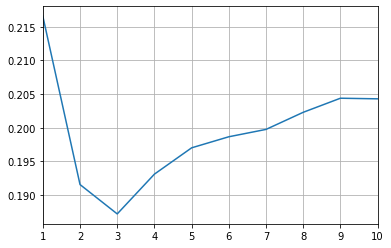

Max mean score 0.21655825523284447 for 1 neighbors


In [35]:
opt_neigh(1, 10, csr, target_tok)

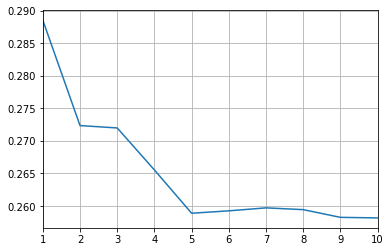

Max mean score 0.28853082572303196 for 1 neighbors


In [36]:
opt_neigh(1, 10, csr, target_tok, 'cosine')

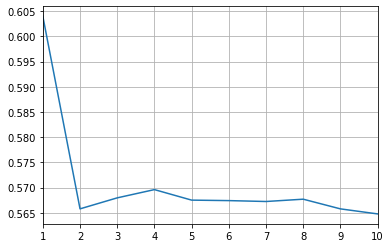

Max mean score 0.6039704266022261 for 1 neighbors


In [37]:
opt_neigh(1, 10, csr, target_tok, tfidf=True)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [38]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [39]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [40]:
data_test_tok = list(map(lambda x: list(
    filter(None, re.sub('[^0-9a-z]+', ' ', x.lower()).split(' '))), data_test))
target_test_tok = target_test.copy()
data_test_tok, target_test_tok = list(
    map(list, zip(*list(filter(lambda x: x[0] != [], zip(data_test_tok, target_test_tok))))))

In [41]:
w_data = []
row_ind = []
col_ind = []
for i, l in enumerate(data_test_tok):
    for w in l:
        if w in words:
            row_ind.append(i)
            col_ind.append(words[w])
            w_data.append(1)

In [42]:
csr_test = csr_matrix((w_data, (row_ind, col_ind)),
                      shape=(len(data_test_tok), len(words)))

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [43]:
csr_trans = TfidfTransformer().fit_transform(csr)
csr_test_trans = TfidfTransformer().fit_transform(csr_test)
clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute')

In [44]:
clf.fit(csr_trans, target_tok)

In [45]:
clf.score(csr_test_trans, target_test_tok)

0.5144342591325762

In [46]:
cross_validate(clf, csr_test_trans, target_test_tok, cv=3)

{'fit_time': array([0.00765896, 0.00430584, 0.00442624]),
 'score_time': array([0.85248113, 0.97922897, 0.86849833]),
 'test_score': array([0.56546645, 0.57019704, 0.56525319])}